In [390]:
import glob
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
import numpy as np

from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     StratifiedKFold, cross_val_score,
                                     train_test_split, cross_validate)
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import shap
import matplotlib as mpl
import matplotlib.pyplot as plt # scripting interface of matplotlib
import seaborn as sns
from scipy import stats
from dython.nominal import associations
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

In [352]:
train = pd.read_csv('train.csv', sep = ',')
test = pd.read_csv('test.csv', sep = ',')

train_d = train.copy()
test_d = test.copy()


In [353]:
#train.head()
#train.info()
#train.shape
#train.describe()
#train.head()
#train.columns

# Cleaning data

## Missing values

In [354]:
#print(train.isna().sum())
combine_all = [train, test, train_d, test_d]

for dataset in combine_all:
    dataset["Age"] = dataset.Age.fillna(dataset.Age.mean())
    dataset = dataset.dropna(subset = ["Embarked"])

## Categorical

In [355]:
#NEW Titles column
combine = [train, test]
for dataset in combine:
    dataset["Title"] = dataset.Name.str.extract(" ([A-Za-z]+)\.", expand=False)
    dataset["Title"] = ["Miss" if title == "Ms" else title for title in dataset.Title]
    dataset["Title"] = ["OtherFormalTitle" if title not in ["Mr", "Miss","Mrs","Master"] else title for title in dataset.Title]

#pd.crosstab(train["Title"], train["Sex"])
#train["Title"] = (train.Name.str.split(', ', expand=True )[1]).str.split(".", expand = True)[0]

In [356]:
combine_d = [train_d, test_d]
for dataset in combine_d:
    dataset["Mr"] = [1 if "Mr." in name else 0 for name in dataset.Name]
    dataset["Miss"] = [1 if "Miss." in name or "Ms." in name else 0 for name in dataset.Name]
    dataset["Mrs"] = [1 if "Mrs." in name else 0 for name in dataset.Name]
    dataset["Master"] = [1 if "Master." in name else 0 for name in dataset.Name]
    #other honorifics are in the "rest" category

In [357]:
#Add family size as its own variable?
for dataset in combine_all:
    dataset["FamilyMembers"] = dataset["SibSp"] + dataset["Parch"]

test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilyMembers
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,2


In [358]:
#Add dummy variables for embarked and sex
test_d = pd.get_dummies(test_d, columns=["Embarked"], drop_first =True)
train_d = pd.get_dummies(train_d, columns=["Embarked"], drop_first =True)

test_d["Male"] = test_d["Sex"].map({"female": 0, "male": 1})
train_d["Male"] = train_d["Sex"].map({"female": 0, "male": 1})

In [359]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilyMembers
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0


In [360]:
#drop_column_train = drop_column_test + []

drop_column_dummy = ["Name", "Ticket", "Sex", "Cabin", "SibSp", "Parch"]
train_d = train_d.drop(drop_column_dummy, axis = 1)
test_d = test_d.drop(drop_column_dummy, axis = 1)

drop_column = ["Name", "Ticket", "Cabin", "SibSp", "Parch"]
train = train.drop(drop_column, axis = 1)
test = test.drop(drop_column, axis = 1)

train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilyMembers
0,1,0,3,male,22.0,7.2500,S,Mr,1
1,2,1,1,female,38.0,71.2833,C,Mrs,1
2,3,1,3,female,26.0,7.9250,S,Miss,0
3,4,1,1,female,35.0,53.1000,S,Mrs,1
4,5,0,3,male,35.0,8.0500,S,Mr,0


## Outliers

In [361]:
#Find outliers in training set
print(train.shape)
print(train_d.shape)

z = np.abs(stats.zscore(train[["Age", "Fare", "FamilyMembers"]])) #, "SibSp", "Parch"
z1 = np.abs(stats.zscore(train[["Age"]])) 
z2 = np.abs(stats.zscore(train[["Fare"]]))
z3 = np.abs(stats.zscore(train[["FamilyMembers"]]))

threshold = 3
print(np.where(z>threshold)[0])
print(len(np.where(z>threshold)[0]))

#print(len(np.where(z1>threshold)[0]))
#print(len(np.where(z2>threshold)[0]))
#print(len(np.where(z3>threshold)[0]))

idx = list(np.where(z>threshold)[0])

(891, 9)
(891, 13)
[ 13  25  27  59  68  71  88  96 116 118 119 159 180 182 201 233 258 261
 299 311 324 341 377 380 386 438 480 493 527 541 542 557 610 630 672 678
 679 683 689 700 716 730 737 742 745 779 792 813 846 850 851 863]
52


In [362]:
#Remove outliers in training set
train = train[~train.index.isin(idx)] # ~ means "not in"
train_d = train_d[~train_d.index.isin(idx)] # ~ means "not in"

print(train.shape)
print(train_d.shape)

(839, 9)
(839, 13)


#### Tansfer passengerID to index

In [363]:
train.set_index("PassengerId", inplace = True)
test.set_index("PassengerId", inplace = True)
train_d.set_index("PassengerId", inplace = True)
test_d.set_index("PassengerId", inplace = True)

# Data exploration

In [364]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 839 entries, 1 to 891
Data columns (total 8 columns):
Survived         839 non-null int64
Pclass           839 non-null int64
Sex              839 non-null object
Age              839 non-null float64
Fare             839 non-null float64
Embarked         837 non-null object
Title            839 non-null object
FamilyMembers    839 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 59.0+ KB


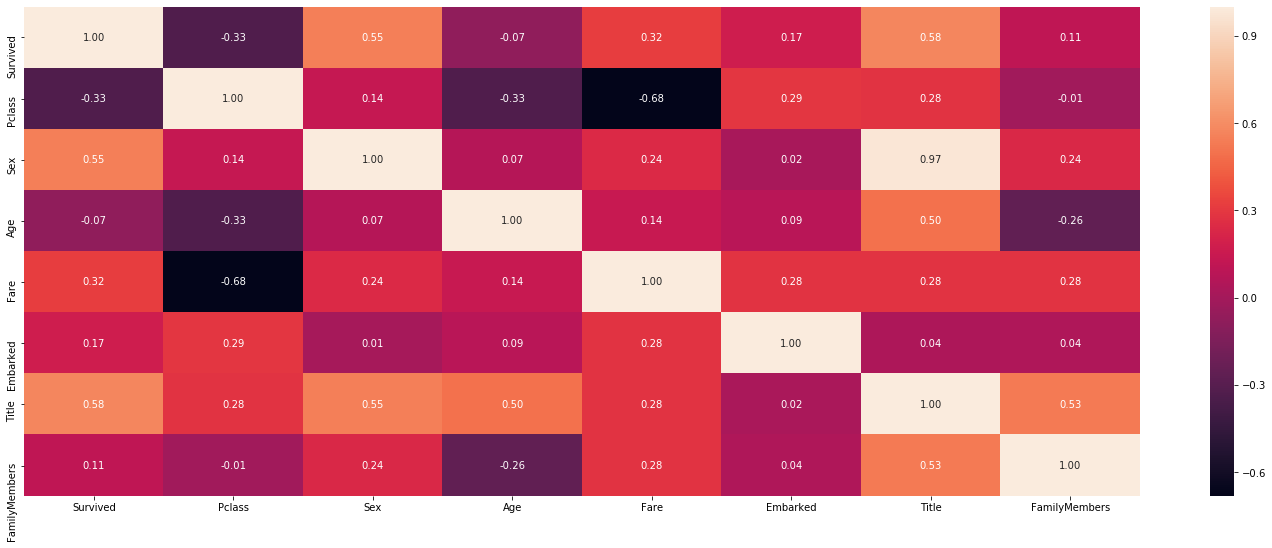

In [365]:
## Correlation
nominal_columns = list(train.select_dtypes(exclude=["number"]).columns)
associations(train,
             nominal_columns=nominal_columns,
             figsize=(25,9),
             theil_u=True)

# Create the default pairplot
#sns.pairplot(train)

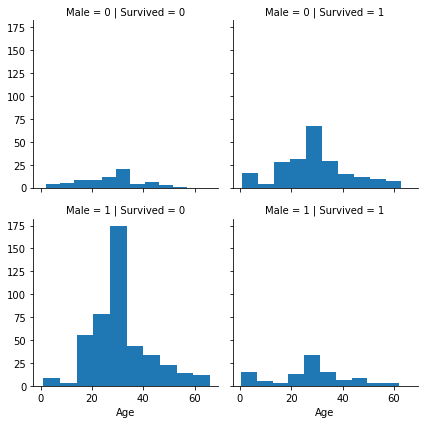

In [366]:
g = sns.FacetGrid(train_d, 
 col="Survived", 
 row="Male")
g = g.map(plt.hist,"Age")

#### Class
Higher class gives higher chance of survival

Pclass
1    0.630208
2    0.475410
3    0.247845
Name: Survived, dtype: float64

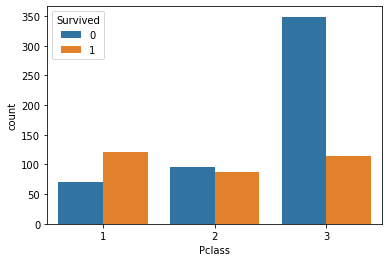

In [367]:
sns.countplot(data=train_d,x='Pclass',hue='Survived')

class_survived = train_d.groupby('Pclass').mean().Survived
class_survived

#### Sex
Females have higher chance of survival

Male
0    0.754325
1    0.190909
Name: Survived, dtype: float64

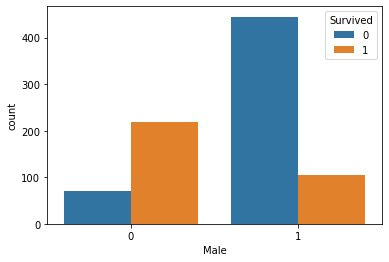

In [368]:
sns.countplot(data=train_d,x='Male',hue='Survived')
sex_survived = train_d.groupby('Male').mean().Survived
sex_survived

#### Age

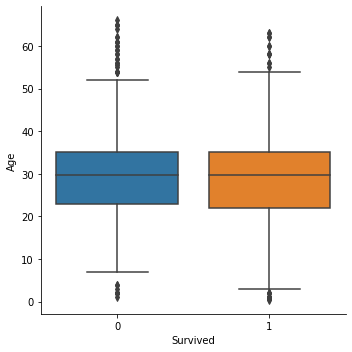

In [369]:
sns.catplot(x = "Survived", y= "Age", kind= "box", data = train_d)

#### Fare

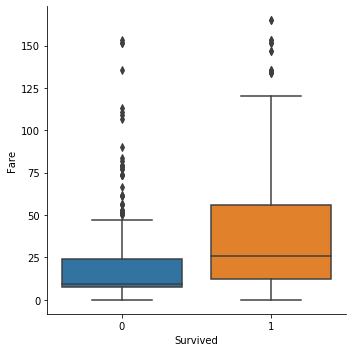

In [370]:
sns.catplot(x = "Survived", y= "Fare", kind= "box", data = train_d)

# ML

In [372]:
train, label = train.drop('Survived', axis=1), train['Survived']
train_d, label_d = train_d.drop('Survived', axis=1), train_d['Survived']

X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.3, random_state =42)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(train_d, label_d, test_size=0.3, random_state =42)

print ("X train dimension:", X_train.shape)
print ("X test dimension:", X_test.shape)

KeyError: "['Survived'] not found in axis"

In [373]:
param_dict = {"objective": "binary:logistic", "n_jobs": -1}

model = XGBClassifier(**param_dict)
model.fit(X_train_d, y_train_d,
         eval_set=[(X_train_d, y_train_d), (X_test_d, y_test_d)],
         eval_metric = "error",
         verbose = False)

predictions = model.predict(X_test_d)
accuracy = round(accuracy_score(y_test_d, predictions)*100, 4)
print ("Accuracy of model is: %.2f%%" % accuracy)


Accuracy of model is: 85.71%


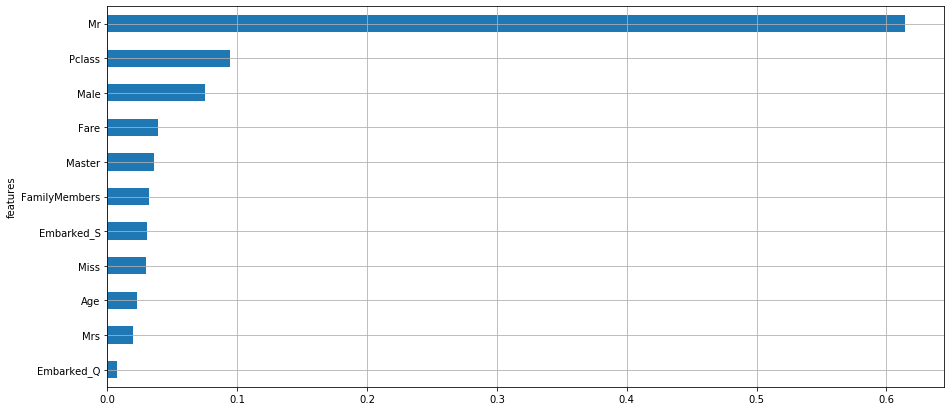

In [375]:
feature_importance = pd.DataFrame(list(zip(X_train_d.columns, model.feature_importances_)), columns=['features', 'importance'])
feature_importance.set_index('features', drop=True, inplace=True)
feature_importance.sort_values(by='importance', ascending=True, inplace=True)
feature_importance.plot(kind='barh', legend=False, grid=True, figsize=[15,7]);

In [376]:
train.head()

,Pclass,Sex,Age,Fare,Embarked,Title,FamilyMembers
PassengerId,,,,,,,
1,3,male,22.0,7.2500,S,Mr,1
2,1,female,38.0,71.2833,C,Mrs,1
3,3,female,26.0,7.9250,S,Miss,0
4,1,female,35.0,53.1000,S,Mrs,1
5,3,male,35.0,8.0500,S,Mr,0


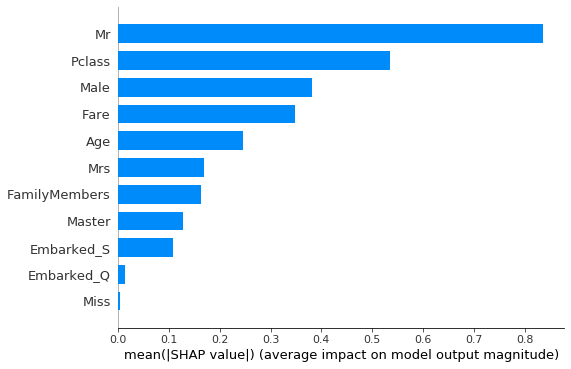

In [378]:
## Shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_d)
shap.summary_plot(shap_values, train_d, plot_type="bar") 
#shap.summary_plot(shap_values, data)

### Logistic Regression model

In [399]:
# Initializing the model
log_reg = LogisticRegression()
log_reg.fit(X_train_d, y_train_d)

# Predicting on test data
prediction_lr = log_reg.predict(X_test_d)
prediction_lr

accuracy_lr =accuracy_score(y_test_d, prediction_lr)*100
print ("Accuracy of logistic regression model is: %.2f%%" % accuracy_lr)

pred_prob_lr = log_reg.predict_proba(X_test_d)

Accuracy of logistic regression model is: 85.71%


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


array([[0.74584791, 0.25415209],
       [0.87392039, 0.12607961],
       [0.18951289, 0.81048711],
       [0.91242822, 0.08757178],
       [0.87742017, 0.12257983],
       [0.86138226, 0.13861774],
       [0.93144612, 0.06855388],
       [0.22261847, 0.77738153],
       [0.83629399, 0.16370601],
       [0.88997475, 0.11002525],
       [0.93192878, 0.06807122],
       [0.03197874, 0.96802126],
       [0.88199381, 0.11800619],
       [0.81764605, 0.18235395],
       [0.8775399 , 0.1224601 ],
       [0.50700487, 0.49299513],
       [0.400325  , 0.599675  ],
       [0.03844111, 0.96155889],
       [0.28957559, 0.71042441],
       [0.93547352, 0.06452648],
       [0.90762224, 0.09237776],
       [0.68397325, 0.31602675],
       [0.84846211, 0.15153789],
       [0.90762224, 0.09237776],
       [0.03911978, 0.96088022],
       [0.0315085 , 0.9684915 ],
       [0.26119078, 0.73880922],
       [0.72686366, 0.27313634],
       [0.69020727, 0.30979273],
       [0.45461608, 0.54538392],
       [0.

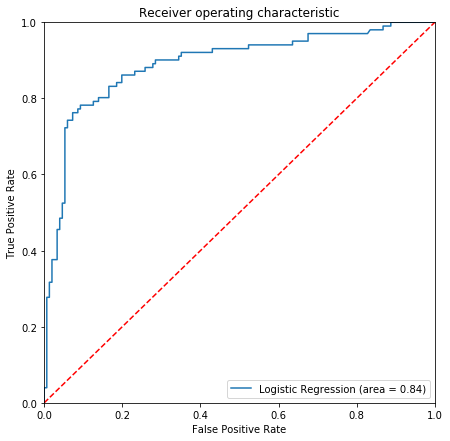

In [400]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
roc_auc = roc_auc_score(y_test, log_reg.predict(X_test_d))
fpr, tpr, thresholds = roc_curve(y_test_d, log_reg.predict_proba(X_test_d)[:,1])
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Random Forest
Hentet fra kurs del 3

In [404]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state = 422, max_depth = 6)
forest_reg.fit(X_train_d, y_train_d)

predictions_rf = forest_reg.predict(X_test_d)

#accuracy_forest = accuracy_score(y_test_d, predictions_rf)*100
#print ("Accuracy of logistic regression model is: %.2f%%" % accuracy_forest)

def RSS(y, p):
    return sum((y - p)**2)

print("RSS for random forest model is {0:.2f}".format(RSS(y_test_d, predictions_rf)))
print('Random forest R^2: %.4f' % forest_reg.score(X_test_d, y_test_d)) 

RSS for random forest model is 29.90
Random forest R^2: 0.5060


### Gradient Boosting
Hentet fra kurs del 3

In [405]:
train_d.head()

,Pclass,Age,Fare,Mr,Miss,Mrs,Master,FamilyMembers,Embarked_Q,Embarked_S,Male
PassengerId,,,,,,,,,,,
1,3,22.0,7.2500,1,0,0,0,1,0,1,1
2,1,38.0,71.2833,0,0,1,0,1,0,0,0
3,3,26.0,7.9250,0,1,0,0,0,0,1,0
4,1,35.0,53.1000,0,0,1,0,1,0,1,0
5,3,35.0,8.0500,1,0,0,0,0,0,1,1


In [ ]:
feature_labels = np.array(['Pclass', 'Age', 'Fare', 'Mr', 'Miss', 'Mrs', 'Master', 'FamilyMembers', 'Embarked_Q', 'Embarked_S', 'Male'])
importance = forest_reg.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

In [ ]:
# excluding the variables where impotance is less than 1%

X = boston_data[['CRIM', 'RM', 'TAX', 'PTRATIO', 'LSTAT', 'AGE', 'B', 'INDUS']]
y = boston_data["MEDV"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 222)

In [ ]:
grad_boost = RandomForestRegressor(random_state = 222, max_depth = 6)

grad_boost.fit(X_train, y_train)

predictions_gb = grad_boost.predict(X_test)

In [ ]:
print("RSS for gradient boosted tree model is {0:.2f}".format(RSS(y_test, predictions_gb)))
print('Gradient boosted tree R^2: %.4f' % grad_boost.score(X_test, y_test)) 

# Submit

In [13]:
result = model.predict(test)
ids = test.index
submit = pd.dataframe({"PassengerId": ids, "Survived": result.astype(int)})
submit.to_csv("submit.csv")
print("Done saving!")

AttributeError: module 'pandas' has no attribute 'dataframe'